In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

N = 5

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=N, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

print("Train set", len(trainset))
print("Test set", len(testset))

Train set 50000
Test set 10000


1. 224.23835875988007
2. 203.76239402294158
3. 194.45452792644483
4. 186.5990280151367
5. 177.18508974313738
6. 172.41383732557298
7. 169.97333595752724
8. 166.5650662541389
9. 163.5436414957047
10. 159.76805865764624
11. 160.45117681026443
12. 158.31219233274453
13. 157.37636336088175
14. 154.08021044731152
15. 151.20623288154616
16. 148.70619165897367
17. 151.3396904349326
18. 147.4895970940589
19. 147.3914176166059
20. 147.37731199264508


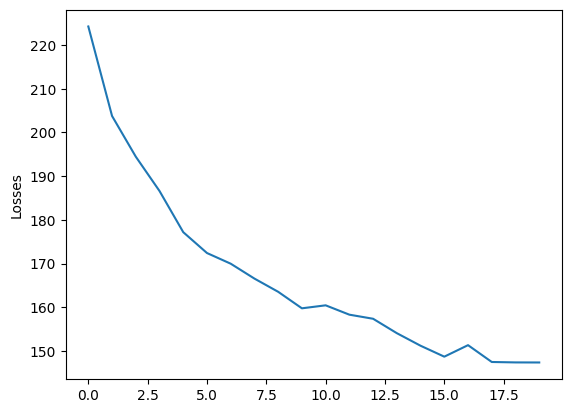

In [6]:
# Train

torch.manual_seed(1234)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 inp chan (rgb), 6 out chan (feature channels == kernel count), 5 for kernel dim
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 2 kernel size (pool window), stride is 2 (skip)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 3)
        self.fc1 = nn.Linear(10 * 6 * 6, 69)
        self.fc2 = nn.Linear(69, 42)
        self.fc3 = nn.Linear(42, 10)

    def forward(self, x):
        # x is (N, 3, 32, 32)
        x = F.relu(self.conv1(x))            # (N, 6, 28, 28)
        x = self.pool(x)                     # (N, 10, 14, 14)
        x = F.relu(self.conv2(x))            # (N, 10, 12, 12)
        x = self.pool(x)                     # (N, 10, 6, 6)
        x = x.view(-1, 10 * 6 * 6)           # (N, 10, 6, 6) -> (N, 10 * 6 * 6)
        x = F.relu(self.fc1(x))              # (N, 69)
        x = F.relu(self.fc2(x))              # (N, 42)
        x = self.fc3(x)                      # (N, 10)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(net.parameters())
losses = []
take_train_max = 500

epochs = 20
for epoch in range(epochs):  
    total_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i >= take_train_max:
            break
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() / N

    losses.append(total_loss)
    print(f"{epoch + 1}. {total_loss}")

plt.plot(losses)
plt.ylabel("Losses")
plt.show()

In [7]:
correct = 0
total = 0
take_test_max = 500
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        if i >= take_test_max:
            break
        images, labels = data
        outputs = net(images)
        _, best_index_per_sample = torch.max(outputs.data, 1)
        assert len(best_index_per_sample) == N

        for pre_idx, true_idx in zip(best_index_per_sample, labels):
            pred, true = classes[pre_idx], classes[true_idx]
            verdict = pred == true
            if total % 100 == 0 or (verdict and torch.rand(1) < 0.5):
                print(f"A {true} is a {pred}? {verdict}")

        correct += (best_index_per_sample == labels).sum().item()
        total += len(labels)

print(f"Accuracy over {epochs} epochs on the {take_test_max} first test images: {100 * correct /  total}%")

A cat is a ship? False
A ship is a car? False
A ship is a car? False
A plane is a car? False
A frog is a truck? False
A car is a car? True
A horse is a horse? True
A dog is a dog? True
A horse is a horse? True
A plane is a plane? True
A truck is a truck? True
A truck is a truck? True
A horse is a horse? True
A truck is a truck? True
A horse is a horse? True
A ship is a ship? True
A cat is a cat? True
A ship is a ship? True
A car is a car? True
A car is a car? True
A bird is a bird? True
A deer is a horse? False
A dog is a car? False
A frog is a dog? False
A cat is a car? False
A car is a car? True
A ship is a ship? True
A car is a car? True
A car is a car? True
A bird is a bird? True
A car is a car? True
A ship is a ship? True
A truck is a truck? True
A truck is a truck? True
A ship is a ship? True
A ship is a ship? True
A horse is a horse? True
A dog is a car? False
A car is a car? True
A ship is a plane? False
A horse is a car? False
A car is a car? True
A dog is a dog? True
A ship i